In [1]:
'''
CIV utility functions
'''
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import norm

In [2]:
def estimate_senior_civ(S, L, T, threshold=0.001, max_steps=100, civ_guess=0.3, max_civ=1.5, verbose=False):
    '''
    estimates stw given current CIV, L, T assuming dollar 1
    params:
    - S (n): spread-to-worst
    - L (n): leverage
    - T (n): time to takeout
    - max_steps (int): max number of iterations
    - civ_guess (float): initial guess used for all CIV
    - max_civ (float): civ upper bound
    - verbose (bool) verbosity
    returns:
    - CIV (n): credit implied volatility
    '''
    step = 0
    CIV = np.full(S.shape, civ_guess)
    while True:
        if step >= max_steps:
            # terminate after max steps taken
            break
        t = np.sqrt(T)
        # d1 = 0.5*CIV*t - ln(l)/(CIV*t)
        # d2 = d1 - CIV*t
        # stw_est = -ln(phi2+(1-phi1)/L)/T
        d1 = 0.5*CIV*t - np.log(L)/(CIV*t)
        d2 = d1-CIV*t
        phi1 = norm.cdf(d1)
        phi2 = norm.cdf(d2)
        S1 = -np.log(np.clip(phi2+(1-phi1)/L, 0.001, None))/T
        err = S1-S
        
        if (np.abs(err) <= threshold).sum() == err.shape[0]:
            # terminate if all err below threshold
            break
    
        # step forward civ estimate
        # dciv = coef*(df1+df2)
        # civ1 = civ0-err/dciv
        coef = -1/(T*(phi2+(1-phi1)/L))
        df1 = -norm.pdf(d1)*(np.log(L)/(CIV**2*t)+0.5*t)/L
        df2 = norm.pdf(d2)*(np.log(L)/(CIV**2*t)-0.5*t)
        dciv = coef*(df1+df2)
        CIV = np.clip(CIV-err/dciv, None, max_civ)
        CIV[np.isnan(CIV)] = max_civ
        step += 1
    
    if verbose:
        print(f'CIV estimate steps: {step}')

    return CIV

In [3]:
S = np.array([0.0096439])
L = np.array([0.279033])
T = np.array([8.7562])
estimate_senior_civ(S, L, T)

array([0.3396761])

In [5]:
# load data from csv
data_url = 'civ_data.csv'
df = pd.read_csv(data_url)
df

,STW,T,L1,L2,ISSUANCE
0,0.057899,3.661111,0.312235,0.670346,FUN 5.375% due 2024
1,0.051510,8.783333,0.312235,0.670346,FUN 5.25% due 2029
2,0.050948,6.533333,0.312235,0.670346,FUN 5.375% due 2027
3,0.066884,3.827778,0.295137,0.650451,SIX 4.875% due 2024
4,0.051004,4.744444,0.295137,0.650451,SIX 7% due 2025
5,0.063540,6.533333,0.295137,0.650451,SIX 5.5% due 2027
6,0.004190,0.952778,0.000000,0.020739,NVDA 2.2% due 2021
7,0.019789,2.033333,0.306476,0.824603,SLG 3.25% due 2022
8,0.028654,5.533333,0.000000,0.425960,GLPI 5.375% due 2026
9,0.030275,7.661111,0.000000,0.425960,GLPI 5.75% due 2028


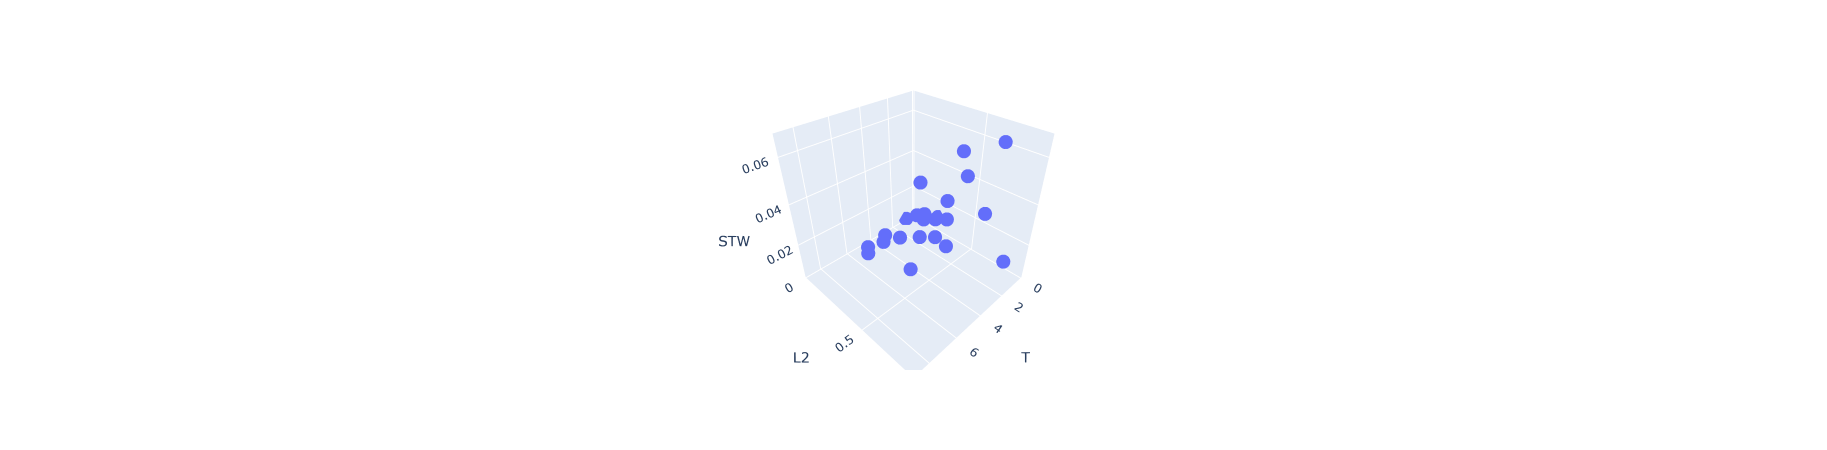

In [7]:
# plot for ending LTV stw/t/l2
fig = px.scatter_3d(df, x='T', y='L2', z='STW', hover_name='ISSUANCE')
fig.show()

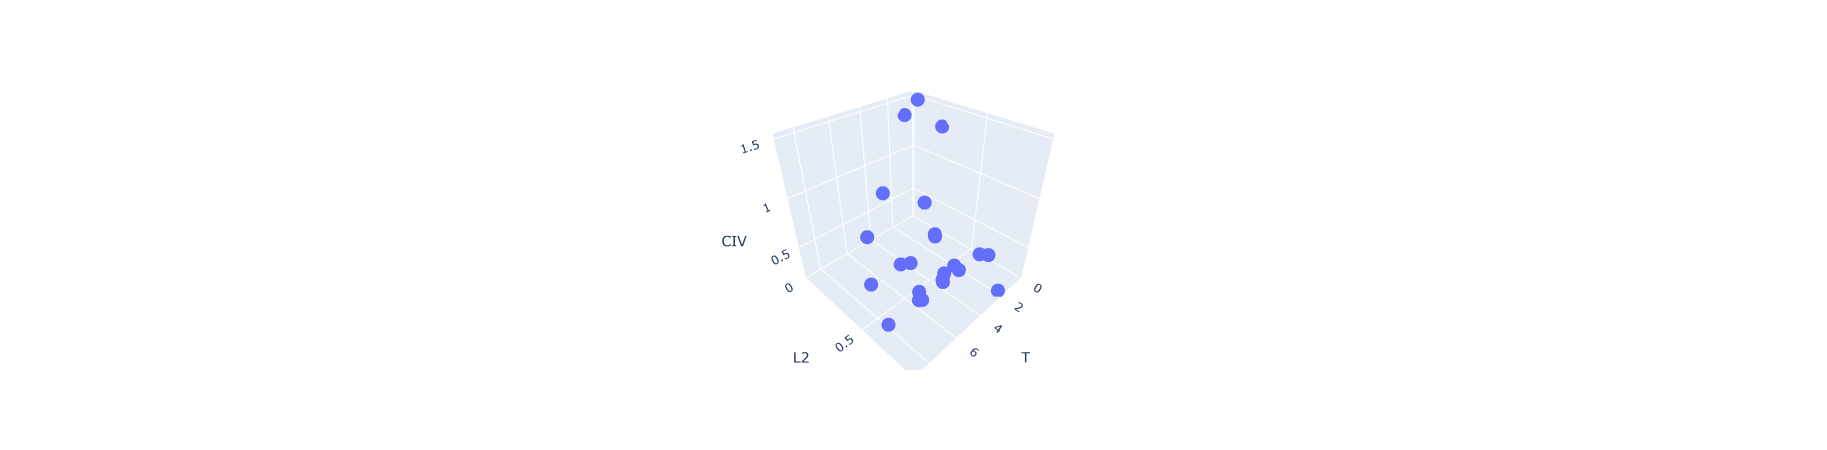

In [10]:
# plot civ
df['CIV'] = estimate_senior_civ(df.STW, df.L2, df['T'])
fig = px.scatter_3d(df, x='T', y='L2', z='CIV', hover_name='ISSUANCE')
fig.show()

In [11]:
# standardize data for RF
mus = df[['T', 'L2']].mean(axis=0)
stds = df[['T', 'L2']].std(axis=0)
X = (df[['T', 'L2']]-mus)/stds
Y = df.CIV

In [12]:
# rf regressor
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)
regr.score(X, Y)

0.928769679630852

In [13]:
# generate predictions and find outliers
preds = regr.predict(X)
errs = preds-Y
z_score_errs = (errs-errs.mean())/errs.std()
df['ZSCORE'] = z_score_errs
df[z_score_errs.abs() >= 1.5]

,STW,T,L1,L2,ISSUANCE,CIV,ZSCORE
6,0.004190,0.952778,0.000000,0.020739,NVDA 2.2% due 2021,1.363941,-2.671116
7,0.019789,2.033333,0.306476,0.824603,SLG 3.25% due 2022,0.185563,1.906713
16,0.005909,0.327778,0.000000,0.065606,NFLX 5.375% due 2021,1.500000,-1.661847
21,0.004182,4.366667,0.027027,0.387686,VZ 3.376% due 2025,0.273706,1.580784


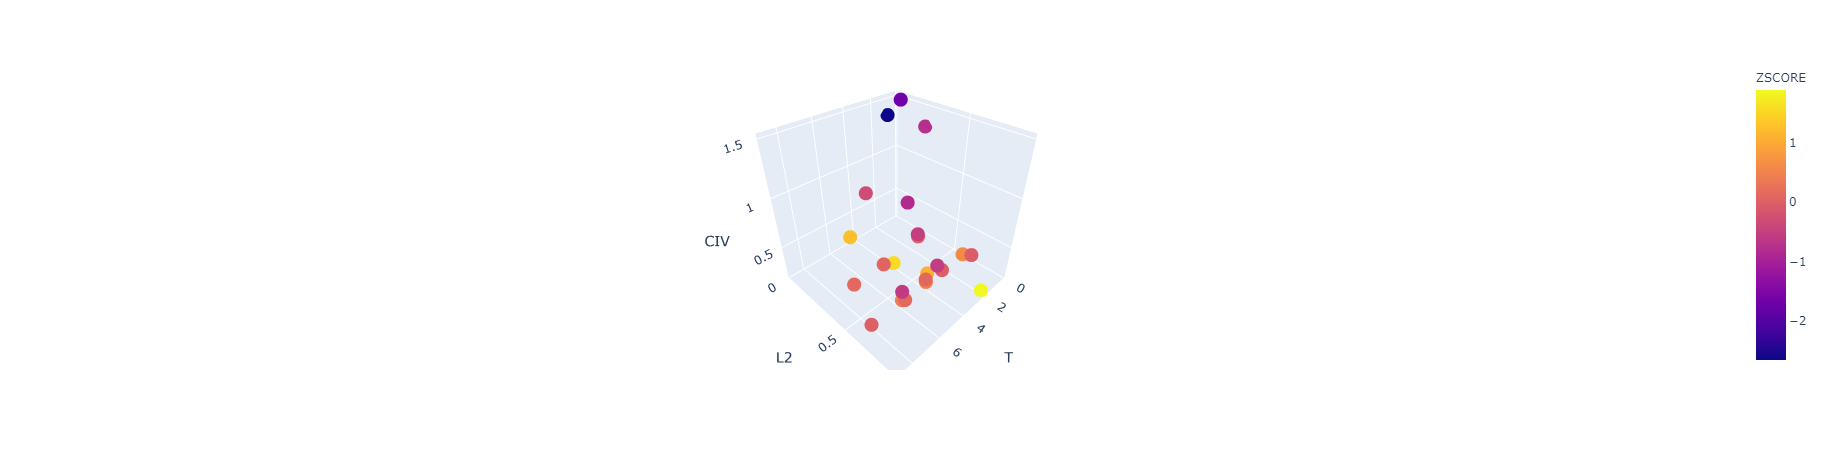

In [14]:
fig = px.scatter_3d(df, x='T', y='L2', z='CIV', hover_name='ISSUANCE', color='ZSCORE')
fig.show()